## Wrangle Phase

In [20]:
import pandas as pd
import datetime as dt
import numpy as np
import requests
import tweepy
import json
import re
from nltk import pos_tag

### Data Initialization

In [21]:
archive = pd.read_csv('twitter-archive-enhanced.csv')
archive.set_index('tweet_id',inplace = True)
archive.head(5)

,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
tweet_id,,,,,,,,,,,,,,,,
892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [22]:
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r=requests.get(url)

with open(url.split('/')[-1],mode='wb') as file:
    file.write(r.content)
imgs=pd.read_csv('image-predictions.tsv',sep='\t')
imgs.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [23]:
cons_key='DYRS3xvS0pjf4vobKxwWXAZcv'
cons_secret_key='QeIJrednkCbaPGybY4VnvKVm0YcT98ORNWB84ffBxBRKQfFSFX'
access_token='392505530-iBcxTZtyFYPF38rmijfl4pB7q5PBY6rN8Y1eM7Rp'
access_secret_token='k4WAEWDzI6gdEaNdUFXkGAgBTMlOo1YTLr97lUaXvxzHw'

auth = tweepy.OAuthHandler(cons_key,cons_secret_key)
auth.set_access_token(access_token,access_secret_token)

api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(),wait_on_rate_limit=True)

### Appending Tweet data to a list

In [25]:
df_list = []
e_list = []
tweet_id = imgs['tweet_id']

for id in tweet_id:
    try:
        page = api.get_status(id)
        favorites = page['favorite_count']
        retweet_count = page['retweet_count']
        day_time = pd.to_datetime(page['created_at'])
        df_list.append({'tweet_id': int(id),
                        'favorites': int(favorites),
                        'retweet_count': int(retweet_count)})
    
    except Exception as e:
        e_list.append(id)

In [26]:
df_list

[{'tweet_id': 666020888022790149, 'favorites': 2560, 'retweet_count': 518},
 {'tweet_id': 666029285002620928, 'favorites': 130, 'retweet_count': 47},
 {'tweet_id': 666033412701032449, 'favorites': 125, 'retweet_count': 44},
 {'tweet_id': 666044226329800704, 'favorites': 299, 'retweet_count': 141},
 {'tweet_id': 666049248165822465, 'favorites': 109, 'retweet_count': 40},
 {'tweet_id': 666050758794694657, 'favorites': 132, 'retweet_count': 58},
 {'tweet_id': 666051853826850816, 'favorites': 1228, 'retweet_count': 854},
 {'tweet_id': 666055525042405380, 'favorites': 436, 'retweet_count': 257},
 {'tweet_id': 666057090499244032, 'favorites': 297, 'retweet_count': 142},
 {'tweet_id': 666058600524156928, 'favorites': 112, 'retweet_count': 57},
 {'tweet_id': 666063827256086533, 'favorites': 479, 'retweet_count': 223},
 {'tweet_id': 666071193221509120, 'favorites': 148, 'retweet_count': 62},
 {'tweet_id': 666073100786774016, 'favorites': 323, 'retweet_count': 166},
 {'tweet_id': 666082916733198

In [27]:
e_list

[802247111496568832,
 837012587749474308,
 842892208864923648,
 861769973181624320,
 873697596434513921,
 888202515573088257]

In [28]:
e1_list = []
for e in e_list:
    try:
        page = api.get_status(e)
        favorites = page['favorite_count']
        retweet_count = page['retweet_count']
        day_time = pd.to_datetime(page['created_at'])
        df_list.append({'tweet_id': int(e),
                        'favorites': int(favorites),
                        'retweet_count': int(retweet_count)})
        
    except Exception:
        e1_list.append(id)

In [29]:
jsondf=pd.DataFrame(df_list,columns=['tweet_id','favorites','retweet_count'])
jsondf.to_csv('tweet_json.txt',encoding='utf-8')

In [30]:
jsondf = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
jsondf.set_index('tweet_id', inplace = True)
jsondf.tail(4)

,Unnamed: 0,favorites,retweet_count
tweet_id,,,
891689557279858688,2065,42190,8707
891815181378084864,2066,25046,4190
892177421306343426,2067,33259,6313
892420643555336193,2068,38826,8592


In [31]:
imgs.set_index('tweet_id', inplace = True)
df = pd.merge(left=archive, right=imgs, left_index=True, right_index=True, how='left')
df = pd.merge(left=df, right=jsondf, left_index=True, right_index=True, how='left')
df.to_csv('dfcopy.csv', encoding = 'utf-8')

In [32]:
df=pd.read_csv('dfcopy.csv')

### Assessing the Structure and integrity of data

In [33]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf,Unnamed: 0,favorites,retweet_count
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000,2075.000000,2075.000000,2.075000e+03,2.075000e+03,2069.000000,2069.000000,2069.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433,1.203855,0.594548,1.345886e-01,6.032417e-02,1034.000000,8532.735621,2872.908652
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237,0.561875,0.271174,1.006657e-01,5.090593e-02,597.413174,12451.250738,4856.082170
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,0.000000,0.000000,13.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000,1.000000,0.364412,5.388625e-02,1.622240e-02,517.000000,1637.000000,613.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000,1.000000,0.588230,1.181810e-01,4.944380e-02,1034.000000,3787.000000,1360.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000,1.000000,0.843855,1.955655e-01,9.180755e-02,1551.000000,10761.000000,3343.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,2068.000000,143456.000000,77382.000000


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                       20

In [35]:
df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,Unnamed: 0,favorites,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,False,bagel,0.085851,False,banana,0.076110,False,2068.0,38826.0,8592.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,True,Pekinese,0.090647,True,papillon,0.068957,True,2067.0,33259.0,6313.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,True,malamute,0.078253,True,kelpie,0.031379,True,2066.0,25046.0,4190.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,2065.0,42190.0,8707.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,2064.0,40345.0,9476.0
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,2063.0,20237.0,3136.0
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,2062.0,11864.0,2088.0
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,...,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,2061.0,65573.0,19045.0
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,...,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,2060.0,27786.0,4299.0
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,...,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,2059.0,31957.0,7475.0


In [36]:
df['rating_numerator'].value_counts()
df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [37]:
df['name'].value_counts()

None        745
a            55
Charlie      12
Lucy         11
Cooper       11
Oliver       11
Penny        10
Lola         10
Tucker       10
Winston       9
Bo            9
Sadie         8
the           8
Daisy         7
Bailey        7
an            7
Buddy         7
Toby          7
Jax           6
Milo          6
Dave          6
Bella         6
Jack          6
Rusty         6
Oscar         6
Scout         6
Koda          6
Stanley       6
Leo           6
Bentley       5
           ... 
Link          1
Iroh          1
Derby         1
Jed           1
Trip          1
Brandy        1
Brownie       1
Crawford      1
Saydee        1
Arlen         1
Spencer       1
Mitch         1
Brockly       1
Cuddles       1
Geoff         1
Halo          1
Kaiya         1
Orion         1
Eazy          1
Rodman        1
Jockson       1
Mosby         1
Lulu          1
Kaia          1
Ralphé        1
Shooter       1
Heinrich      1
Ruffles       1
Superpup      1
Dido          1
Name: name, Length: 957,

### Data Cleansing

In [38]:
del df['Unnamed: 0']

In [39]:
list(df)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'favorites',
 'retweet_count']

### Creating #Hashtag columns

In [40]:
df['hashtag']=df['text'].str.extract(r"#(\w+)",expand=True)
df['hashtag'].value_counts()

BarkWeek                 9
PrideMonth               3
BATP                     1
dogsatpollingstations    1
FinalFur                 1
LoveTwitter              1
ImWithThor               1
ScienceMarch             1
WomensMarch              1
K9VeteransDay            1
GoodDogs                 1
Canada150                1
WKCDogShow               1
PrideMonthPuppo          1
BellLetsTalk             1
notallpuppers            1
NoDaysOff                1
Name: hashtag, dtype: int64

### Timestamp to Datetime conversion

In [41]:
df['timestamp']=pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                 

### Removing tweets and retweets without Pictures

In [42]:
df=df[pd.notnull(df['jpg_url'])]#nopics
df=df[pd.isnull(df['retweeted_status_id'])]#retweets

In [43]:
len(df['text'])

1994

In [44]:
del df['retweeted_status_id']
del df['retweeted_status_user_id']
del df['retweeted_status_timestamp']

In [45]:
list(df)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'favorites',
 'retweet_count',
 'hashtag']

### Condensing the column - 'Dog_Type'

In [46]:
dog_type=[]
string_in=['puppo','pupper','doggo','floof']
string_out=['puppo','pupper','doggo','floofer']

for row in df['text']:
    row=row.lower()
    for word in string_in:
        if word in str(row):
            dog_type.append(string_out[string_in.index(word)])
            break
    else:
            dog_type.append('None')
        
df['dog_type'] = dog_type
df['dog_type'].value_counts()


None       1625
pupper      237
doggo        69
floofer      34
puppo        29
Name: dog_type, dtype: int64

In [47]:
df.drop(['doggo','floofer','pupper','puppo'],axis=1,inplace=True)

### Condensing - Dog-Breed-Analysis

In [48]:
# condense
breed = []
confidence = []

def breed_confidence(row):
    if row['p1_dog'] == True:
        breed.append(row['p1'])
        confidence.append(row['p1_conf'])
    elif row['p2_dog'] == True:
        breed.append(row['p2'])
        confidence.append(row['p2_conf'])
    elif row['p3_dog'] == True:
        breed.append(row['p3'])
        confidence.append(row['p3_conf'])
    else:
        breed.append('Unidentifiable')
        confidence.append(0)

In [49]:
df.apply(breed_confidence,axis=1)
df['breed'] = breed
df['confidence'] =  confidence
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p2_dog,p3,p3_conf,p3_dog,favorites,retweet_count,hashtag,dog_type,breed,confidence
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,False,banana,0.076110,False,38826.0,8592.0,NaN,None,Unidentifiable,0.000000
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,True,papillon,0.068957,True,33259.0,6313.0,NaN,None,Chihuahua,0.323581
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,...,True,kelpie,0.031379,True,25046.0,4190.0,NaN,None,Chihuahua,0.716012
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,...,True,spatula,0.040836,False,42190.0,8707.0,NaN,None,Labrador_retriever,0.168086
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,...,True,German_short-haired_pointer,0.175219,True,40345.0,9476.0,BarkWeek,None,basset,0.555712


In [50]:
df.drop(['p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog',],axis=1,inplace=True)
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,favorites,retweet_count,hashtag,dog_type,breed,confidence
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,38826.0,8592.0,NaN,None,Unidentifiable,0.000000
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,33259.0,6313.0,NaN,None,Chihuahua,0.323581
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,25046.0,4190.0,NaN,None,Chihuahua,0.716012
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,42190.0,8707.0,NaN,None,Labrador_retriever,0.168086
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,40345.0,9476.0,BarkWeek,None,basset,0.555712


### Ignoring Redundant columns

In [51]:
df['in_reply_to_status_id'].value_counts()
df['in_reply_to_user_id'].value_counts()

4.196984e+09    23
Name: in_reply_to_user_id, dtype: int64

In [52]:
df.drop(['in_reply_to_status_id','in_reply_to_user_id'],axis=1,inplace=True)

In [53]:
df['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1955
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

### Parsing Dog rates and Dog count

In [54]:
rates = []

extract_rates = lambda x: rates.append(re.findall(r'(\d+(\.\d+)|(\d+))\/(\d+0)', x, flags=0))

df['text'].apply(extract_rates)

numerator = []
dog_count = []

for item in rates:
    
    # no rating
    if len(item) == 0:
        numerator.append('NaN')
        dog_count.append(1)
        
    # one rating and one dog
    elif len(item) == 1 and item[0][-1] == '10':
        numerator.append(float(item[0][0]))
        dog_count.append(1)
   
    # fgroup ratings
    elif len(item) == 1: 
        avg = float(item[0][0]) / (float(item[0][-1]) / 10) 
        numerator.append(avg)
        dog_count.append(float(item[0][-1]) / 10)
   
    # ftweets with more than 1 rating
    elif len(item) > 1: 
        total = 0
        list = []
        for i in range(len(item)):
            if item[i][-1] == '10': 
                list.append(item[i])
        for rate in list:
            total = total + float(rate[0])
        avg = total / len(item)
        numerator.append(avg)
        dog_count.append(len(item))
   
    # exceptions
    else:
        numerator.append('Not Parsed')
        dog_count.append('Not Parsed') 
        
df['rating'] = numerator 
df['dog_count'] = dog_count
df['rating'].value_counts()

12.0                 453
10.0                 411
11.0                 399
13.0                 261
9.0                  152
8.0                   94
7.0                   52
14.0                  36
6.0                   32
5.0                   30
3.0                   19
4.0                   14
2.0                    9
1.0                    4
8.5                    4
7.5                    3
9.5                    3
5.5                    2
6.5                    2
10.5                   2
0.0                    2
1776.0                 1
9.75                   1
9.666666666666666      1
11.26                  1
4.5                    1
11.27                  1
13.5                   1
420.0                  1
11.5                   1
NaN                    1
Name: rating, dtype: int64

In [55]:
# Only two values are high 
df.drop(['rating_numerator','rating_denominator'],axis=1, inplace = True) #values are in 'rating'

In [56]:
df['dog_count'].value_counts()

1.0     1958
2.0       23
5.0        2
8.0        2
3.0        1
12.0       1
11.0       1
13.0       1
4.0        1
9.0        1
17.0       1
15.0       1
7.0        1
Name: dog_count, dtype: int64

### Fetching Dog Names

In [57]:
df['text_split'] = df['text'].str.split()#for names

In [58]:
names = []

def get_names(row):
    
    if row['text'].startswith('This is ') and re.match(r'[A-Z].*', row['text_split'][2]):
            names.append(row['text_split'][2].strip('.').strip(','))
    
    elif row['text'].startswith('Meet ') and re.match(r'[A-Z].*', row['text_split'][1]):
            names.append(row['text_split'][1].strip('.').strip(','))
    
    elif row['text'].startswith('Say hello to ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
    
    elif row['text'].startswith('Here we have ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
              
    elif 'named' in row['text'] and re.match(r'[A-Z].*', row['text_split'][(row['text_split'].index('named') + 1)]): 
            names.append(row['text_split'][(row['text_split'].index('named') + 1)])
            
    else:
        names.append('Nameless')
        
        
df.apply(get_names, axis=1)

len(names)
df['names'] = names
df['names'].value_counts()


Nameless    625
Charlie      11
Cooper       10
Oliver       10
Lucy         10
Tucker        9
Penny         9
Winston       8
Sadie         8
Lola          7
Daisy         7
Jax           6
Bo            6
Bella         6
Toby          6
Stanley       6
Koda          6
Leo           5
Oscar         5
Rusty         5
Chester       5
Louis         5
Milo          5
Buddy         5
Bailey        5
Scout         5
Archie        4
Dexter        4
Jack          4
Alfie         4
           ... 
Chompsky      1
Kevon         1
Ambrose       1
Orion         1
Dawn          1
Brandi        1
Burke         1
Lucky         1
Clyde         1
Ozzie         1
BeBe          1
Sailer        1
Shadoe        1
Banjo         1
Johm.         1
Pepper        1
Mairi         1
Hamrick       1
Crawford      1
Benny         1
Mack          1
Finnegus      1
Arlen         1
Spencer       1
Mitch         1
Brockly       1
Cuddles       1
Geoff         1
Leela         1
Dido          1
Name: names, Length: 938

In [59]:
df['name'].value_counts()

None        546
a            55
Charlie      11
Oliver       10
Cooper       10
Lucy         10
Tucker        9
Penny         9
Sadie         8
Winston       8
Lola          7
Daisy         7
the           7
Toby          7
an            6
Jax           6
Bo            6
Stanley       6
Bella         6
Koda          6
Buddy         5
Oscar         5
Bailey        5
Scout         5
Louis         5
Chester       5
Dave          5
Rusty         5
Leo           5
Milo          5
           ... 
Acro          1
Einstein      1
Poppy         1
Griswold      1
Kaia          1
Lulu          1
Mosby         1
Jockson       1
Shadoe        1
Banjo         1
Pepper        1
Mairi         1
Hamrick       1
Benny         1
Mack          1
Finnegus      1
Arlen         1
Spencer       1
Mitch         1
Brockly       1
Cuddles       1
Geoff         1
Leela         1
Halo          1
Dawn          1
Kaiya         1
Orion         1
Saydee        1
Eazy          1
Dido          1
Name: name, Length: 936,

### Parsing Dog Gender

In [60]:
# And now for parsing genders....
tagger = lambda x: pos_tag(x)
df['tagged'] = df['text_split'].apply(tagger)

In [61]:
pronoun = lambda x: [word for word, pos in x if pos == 'PRP']
df['pronouns'] = df['tagged'].apply(pronoun)
lowerer = lambda x: [a.lower() for a in x]
df['pronouns'] = df['pronouns'].apply(lowerer)
df['pronouns'].head(5)

0                    []
1                    []
2             [he, you]
3             [she, us]
4    [he, you, him, he]
Name: pronouns, dtype: object

In [62]:
pronouns = df['pronouns']
pronouns.to_csv('pronouns.csv')

In [63]:
gender = []

male=['he',"he's",'his','him','himself']
female=['she',"she's",'her','hers','herself']

def genders(row):
    row['text'] = row['text'].islower()
    if len(row['pronouns']) > 0 and any(i in female for i in row['pronouns']):
        gender.append('Female')
    elif len(row['pronouns']) > 0 and any(i in male for i in row['pronouns']):
        gender.append('Male') 
    elif 'girl' in str(row['text']):
        gender.append('Female')   
    elif 'boy' in str(row['text']):
        gender.append('Male')
    else:
        gender.append('Not Specified')
        
df.apply(genders, axis=1)
df['gender'] = gender
df['gender'].value_counts()


Not Specified    1287
Male              529
Female            178
Name: gender, dtype: int64

In [64]:
df.drop(['text_split', 'tagged', 'pronouns'], axis=1, inplace=True)

In [65]:
df.head(10)

,tweet_id,timestamp,source,text,expanded_urls,name,jpg_url,img_num,favorites,retweet_count,hashtag,dog_type,breed,confidence,rating,dog_count,names,gender
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,38826.0,8592.0,NaN,None,Unidentifiable,0.000000,13,1.0,Phineas,Not Specified
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,33259.0,6313.0,NaN,None,Chihuahua,0.323581,13,1.0,Tilly,Not Specified
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,25046.0,4190.0,NaN,None,Chihuahua,0.716012,12,1.0,Archie,Male
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,42190.0,8707.0,NaN,None,Labrador_retriever,0.168086,13,1.0,Darla,Female
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,40345.0,9476.0,BarkWeek,None,basset,0.555712,12,1.0,Franklin,Male
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1.0,20237.0,3136.0,BarkWeek,None,Chesapeake_Bay_retriever,0.425595,13,1.0,Nameless,Not Specified
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",Jax,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1.0,11864.0,2088.0,NaN,None,Appenzeller,0.341703,13,1.0,Jax,Male
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,None,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2.0,65573.0,19045.0,NaN,None,Pomeranian,0.566142,13,1.0,Nameless,Not Specified
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,Zoey,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1.0,27786.0,4299.0,BarkWeek,None,Irish_terrier,0.487574,13,1.0,Zoey,Female
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,Cassie,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1.0,31957.0,7475.0,NaN,doggo,Pembroke,0.511319,14,1.0,Cassie,Female


### Null Values

In [66]:
df.loc[df['gender'] == 'Not Specified', 'gender'] = None
df.loc[df['names'] == 'Nameless', 'names'] = None
df.loc[df['breed'] == 'Unidentifiable', 'breed'] = None
df.loc[df['dog_type'] == 'None', 'dog_type'] = None
df.loc[df['rating'] == 0.0, 'rating'] = np.nan
df.loc[df['confidence'] == 0.0, 'confidence'] = np.nan
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id         1994 non-null int64
timestamp        1994 non-null datetime64[ns]
source           1994 non-null object
text             1994 non-null object
expanded_urls    1994 non-null object
name             1994 non-null object
jpg_url          1994 non-null object
img_num          1994 non-null float64
favorites        1994 non-null float64
retweet_count    1994 non-null float64
hashtag          22 non-null object
dog_type         369 non-null object
breed            1686 non-null object
confidence       1686 non-null float64
rating           1992 non-null object
dog_count        1994 non-null float64
names            1369 non-null object
gender           707 non-null object
dtypes: datetime64[ns](1), float64(5), int64(1), object(11)
memory usage: 296.0+ KB


### Saving the improved Dataset

In [67]:
df.to_csv('twitter_archive_save.csv', encoding = 'utf-8')

## Analysis Phase

In [71]:
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
df = pd.read_csv('twitter_archive_save.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

### Correlation over favourites, ratings and retweets

Text(0,0.5,'Count')

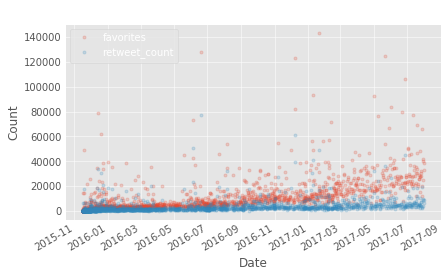

In [70]:
df[['favorites','retweet_count']].plot(style = '.', alpha = .2)
plt.title('Favorites and Retweets over Time')
plt.xlabel('Date')
plt.ylabel('Count')

Text(0,0.5,'Rating')

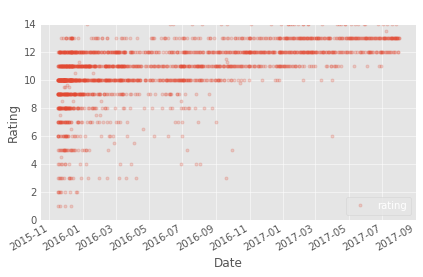

In [72]:
df.plot(y ='rating', ylim=[0,14], style = '.', alpha = .2)
plt.title('Rating Increase over Time')
plt.xlabel('Date')
plt.ylabel('Rating')

In [73]:
df[['favorites', 'retweet_count', 'rating']].corr(method='pearson')

,favorites,retweet_count,rating
favorites,1.000000,0.917332,0.022685
retweet_count,0.917332,1.000000,0.023370
rating,0.022685,0.023370,1.000000


### Gender Distribution

Text(0.5,1,'Dog Genders')

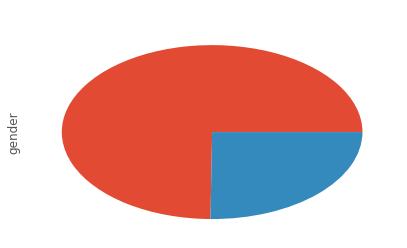

In [74]:
df[df['gender'].notnull()]['gender'].value_counts().plot(kind = 'pie')
plt.title('Dog Genders')

### Most rated

Text(0,0.5,'Breed')

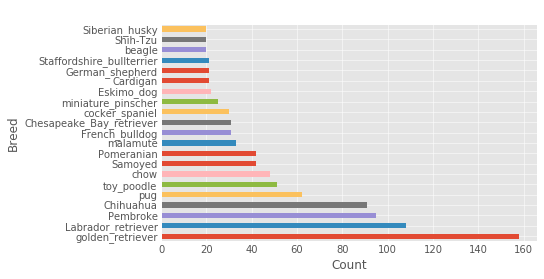

In [75]:
top_breeds=df.groupby('breed').filter(lambda x: len(x) >= 20)
top_breeds['breed'].value_counts().plot(kind = 'barh')
plt.title('Histogram of Most The Rated Breeds')
plt.xlabel('Count')
plt.ylabel('Breed')

In [76]:
top_breeds.groupby('breed')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
breed,,,,,,,,
Cardigan,21.0,11.142857,1.590148,7.0,10.00,11.00,12.0,13.0
Chesapeake_Bay_retriever,31.0,10.741935,1.510358,8.0,10.00,10.00,12.0,13.0
Chihuahua,91.0,10.516484,2.071568,3.0,9.50,11.00,12.0,14.0
Eskimo_dog,22.0,11.409091,1.402688,9.0,10.00,12.00,12.0,14.0
French_bulldog,31.0,11.193548,1.796652,8.0,10.00,12.00,12.0,14.0
German_shepherd,21.0,11.000000,1.449138,8.0,10.00,11.00,12.0,13.0
Labrador_retriever,108.0,11.180556,1.324567,7.0,10.00,11.00,12.0,14.0
Pembroke,95.0,11.389474,1.746088,4.0,11.00,12.00,12.0,14.0
Pomeranian,42.0,10.779762,1.619435,6.0,10.00,11.00,12.0,14.0


In [77]:
df['rating'].describe()

count    1991.000000
mean       11.647638
std        40.668547
min         1.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating, dtype: float64

In [79]:
df[df['rating'] <= 14]['rating'].describe()

count    1989.000000
mean       10.555277
std         2.157977
min         1.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating, dtype: float64

### Dog Statistics

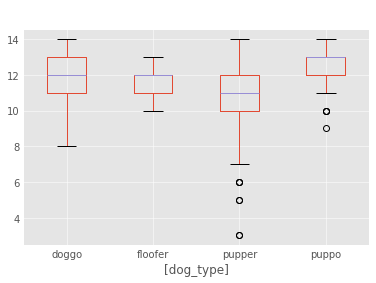

In [80]:
df.boxplot(column=['rating'], by=['dog_type'])

In [81]:
df.groupby('dog_type')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_type,,,,,,,,
doggo,69.0,11.797101,1.510548,8.0,11.0,12.0,13.0,14.0
floofer,34.0,11.705882,0.759961,10.0,11.0,12.0,12.0,13.0
pupper,237.0,10.616160,1.833623,3.0,10.0,11.0,12.0,14.0
puppo,29.0,12.172414,1.197288,9.0,12.0,13.0,13.0,14.0


In [82]:
df.reset_index(inplace=True)
df.groupby('dog_type')['timestamp'].describe()

,count,unique,top,freq,first,last
dog_type,,,,,,
doggo,69,69,2016-11-18 23:35:32,1,2016-04-02 01:52:38,2017-07-26 15:59:51
floofer,34,34,2016-07-05 20:41:01,1,2016-01-08 03:50:03,2017-07-18 00:07:08
pupper,237,237,2016-01-30 02:41:58,1,2015-11-26 21:36:12,2017-07-15 23:25:31
puppo,29,29,2017-01-29 02:44:34,1,2016-06-03 01:07:16,2017-07-25 01:55:32
